In [27]:
import numpy as np
import matplotlib.pyplot as plt
import prop
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy.integrate import ode, simpson
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

# 1. Исходные данные

In [2]:
t = 0.7 #время работы, с  
p = 4.5e6 # полное давление в камере, Па
J_eff = 15 # Эффективный импульс, Нс 
# Топливо
propel = prop.get_propellant('T-3')

p_atm = 1e5
T_min = 273-50
T_max = 273+50
T_N = 273+18

['P-1', '1600', '1030000', '360', '2860', '1.2', '2150', '400', '0', '0\n']
['P-2', '1620', '1040000', '349', '2980', '1.24', '2250', '278', '0', '0\n']
['P-3', '1650', '1040000', '359', '2900', '1.25', '2200', '400', '0', '0\n']
['B-1', '1610', '920000', '347', '2655', '1.24', '2200', '280', '0', '0\n']
['B-2', '1620', '1035000', '345', '3000', '1.23', '2250', '310', '0', '0\n']
['B-3', '1640', '1040000', '338', '3080', '1.25', '2300', '370', '0', '0\n']
['C-1', '1780', '1020000', '298', '3420', '1.17', '2600', '320', '0', '0\n']
['T-1', '1590', '0', '370.5', '2035', '1.26', '1979.6', '320', '8.58', '-0.151\n']
['T-2', '1650', '0', '321.4', '2600', '1.246', '2234.4', '320', '7.58', '0.0768\n']
['T-3', '1590', '0', '367.6', '2047', '1.24', '1979.6', '320', '6.45', '-0.095\n']


# 2. Расчётные формулы

In [3]:
R = J_eff/t  # реактивная сила, Н
G_t = R/propel.I_ud  # расход топлива, кг/с
omega = G_t*t  # масса топлива, кг
u = propel.u_1*1e-3*(p*1e-6)**propel.nu  # скорость горения (мм/с)
S = G_t/(u*propel.rho)   # площадь поверхности горения, м2
def A(k):
    return np.sqrt(k * (2 / (k + 1))**((k+1) / (k - 1)))
A_1 = A(propel.k) # постоянная расхода
F_dr = G_t * np.sqrt(propel.R * propel.T0) / (A_1 * p) # площадь дроссельного отверстия, м2
F_kr = F_dr
d_kr = np.sqrt(4 * F_dr / np.pi) # диаметр дроссельного отверстия, м
e_0 = u * t # толщина горящего свода, м
print("R =", R)
print("G_t =", G_t)
print("omega =", omega)
print("u =", u)
print("S =", S)
print("A_1 =", A_1)
print("F_dr =", F_dr)
print("d_kr =", d_kr)
print("e =", e_0)


R = 21.42857142857143
G_t = 0.010824697630112868
omega = 0.007577288341079007
u = 0.005591193541793974
S = 0.0012176265908162797
A_1 = 0.6561856622944262
F_dr = 3.1799712680575017e-06
d_kr = 0.0020121792091194143
e = 0.003913835479255782


# 3. Рациональный вариант

In [53]:
m = 1 # т.к. количесвто шашек
D_N = 24e-3
print("D_N, мм =", D_N*1e3)
D_V=(D_N-4*e_0)
print("D_V, мм =", D_V*1e3)
L_z = 21e-3
print("L_z, мм =", L_z*1e3)

D_N, мм = 24.0
D_V, мм = 8.344658082976872
L_z, мм = 21.0


# 4. Расчёт формы заряда

S_sr = 0.002133888544543431
S_g = 0.0012176265908162797


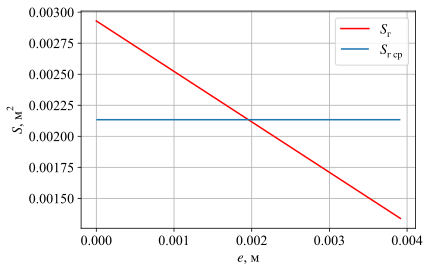

In [54]:
def S_zar(e):
    return (np.pi * (D_V + 2*e)*(L_z - 2*e) + np.pi * (D_N - 2*e) * (L_z - 2*e) + \
        np.pi * 0.5 * (((D_N - 2*e) ** 2) - ((D_V + 2*e) ** 2)))

e = np.linspace(0, e_0, 100)
s = np.array([S_zar(ex) for ex in e])
plt.plot(e, s, color='red', label='$\mathit{S}_{\mathrm{г}}$')
plt.hlines(s.mean(), xmin=0, xmax=e_0,
           label='$\mathit{S}_{\mathrm{г\;ср}}$')
plt.legend()
plt.xlabel('$\mathit{e}$, м')
plt.ylabel('$\mathit{S}$, $м^2$')
plt.grid()                                                                                                          
S_sr = s.mean()
print("S_sr =", S_sr)
print("S_g =", S)

# 4. Расчёт воспламенителя

In [55]:
class Vosplamenitel:
    def __init__(self, F_kr, F_oxl, W_0, e_0 = 0.6e-2, m = 3) -> None:
        self.R = 314
        self.Q = 3050e3
        self.u = 0.05
        self.k = 1.25
        self.rho = 1700
        self.m = m

        self.t_v = e_0 / self.u
        self.T_v = ((self.k - 1) / self.k) * (self.Q / self.R)
        
        self.p_vsp_50 = self.p_vsp(T_min)
        self.p_max = 1.1 * self.p_vsp_50

        b21 = (self.k - 1) / W_0  *  (propel.nu_t * propel.sigma_t * F_oxl) / self.R
        b22 = self.k / W_0 * A(self.k) * F_kr * np.sqrt(self.R * self.T_v)
        self.b2 = b21 + b22
        
        S0_v1 = self.p_max * self.b2 * ((self.m / (self.t_v * self.b2)) ** (-self.m / (self.t_v * self.b2 - self.m)))
        S0_v2 = (self.k - 1) * self.u * self.rho * self.Q
        self.S0_v = S0_v1 / S0_v2 * W_0
        self.b1 = ((self.k-1) / W_0) * self.rho * self.S0_v * self.u * self.Q

        self.omega = e_0 * self.rho * self.S0_v * ((1 - np.exp(- self.m)) / self.m)
        #print(self.omega)
        self.__t_vs = np.linspace(0,0.2,2000)
        self.__p_vs = np.array([self.p_v(t) for t in self.__t_vs])

        self.t_vsp = self.__t_vs[self.__p_vs >= self.p_vsp_50][0]

    def p_vsp(self,T_n):
        """Давление вспышки в зависимости от начальной температуры

        Args:
            T_n (float): начальная температура, К

        Returns:
            p_vsp: давление вспышки, Па
        """
        return propel.c_t * propel.rho / propel.sigma_t * propel.u(1e6, T_n) * self.R * self.T_v * (propel.T_s - T_n) / (self.T_v - propel.T_s)

    def p_v(self,t):
        """Зависимость давления от времени при автономном горения воспламенителя

        Args:
            t (float): время, с

        Returns:
            p: давление, Па
        """
        p1 = p_atm + self.b1 / ((self.m / self.t_v) - self.b2)
        p2 = self.b1 / ((self.m / self.t_v) - self.b2)
        return p1 * np.exp(- self.b2 * t) - p2 * np.exp(- self.m * t / self.t_v)

    def S(self,t):
        """Закон горения воспламенителя

        Args:
            t (float): время, с

        Returns:
            S: площадь горения, м2
        """
        return self.S0_v * np.exp(-self.m * t / self.t_v)

    def get_results(self, figure_filename = 'График p_vospl.svg'):
        """Получение результатов расчета воспламенителя

        Args:
            figure_filename (str, optional): название картинки. Defaults to 'График p_vospl.svg'.
        """
        print(f'Температура продуктов сгорания воспламенителя Tв = {self.T_v:.0f} К\n',
              f'Давление вспышки основного заряда при T_min p_vsp(T_min) = {self.p_vsp_50/1e6:.3f} МПа\n',
              f'Максимальное давление воспламенителя p_max = {self.p_max/1e6:.3f} МПа\n',
              f'Начальная площадь поверхности горения S0в = {self.S0_v:.5f} м2\n',
              f'Масса навески воспламенителя omega_в = {self.omega} г\n',
              f'Время воспламенения основного заряда t_v = {self.t_vsp*1e3:.1f} мс')

        plt.figure(figsize=(9, 6))
        plt.plot(self.__t_vs[self.__p_vs >= p_atm], self.__p_vs[self.__p_vs >= p_atm]/1e6)
        plt.axhline(self.p_vsp_50/1e6, linestyle = '--', color = 'tab:red', label = '$\mathit{p}_{всп}$ = '+f'{self.p_vsp_50/1e6:.3f} МПа')

        plt.legend(loc = 'upper right')
        plt.grid()
        plt.xlabel('$\mathit{t}, с$')
        plt.ylabel('$\mathit{p}, МПа$')
        if figure_filename:
            plt.savefig(figure_filename, dpi=300, bbox_inches='tight')

        plt.show()

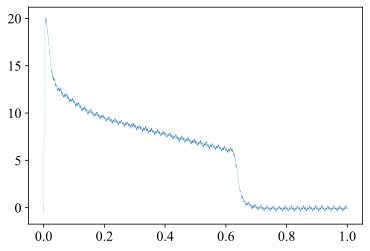

In [56]:
x, y = [], []
with open('RS_T500_140_1.txt') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split('\t')
        try:
            x.append(float(line[0].replace(',', '.')))
            y.append(float(line[1].strip('\n').replace(',', '.'))/10)
        except:
            pass
plt.plot(x, y, linewidth= 0.1)
plt.show()

Начальный свободный объем W0 = 0.037 * 10^5 м3
 Площадь, омываемая ПС F_oxl = 0.0015 м2
Температура продуктов сгорания воспламенителя Tв = 1943 К
 Давление вспышки основного заряда при T_min p_vsp(T_min) = 5.046 МПа
 Максимальное давление воспламенителя p_max = 5.550 МПа
 Начальная площадь поверхности горения S0в = 0.00020 м2
 Масса навески воспламенителя omega_в = 0.0006498555195712359 г
 Время воспламенения основного заряда t_v = 0.4 мс


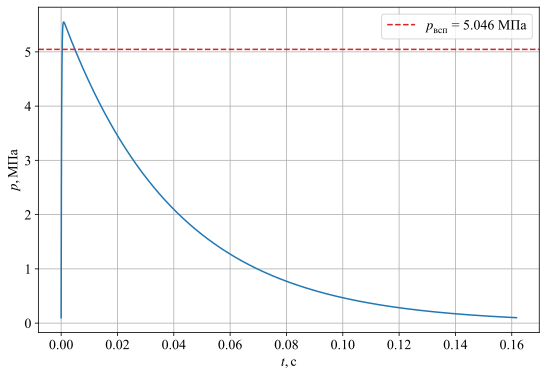

0.12

In [57]:
W_0 = np.pi / 4 * (23e-3)**2 * L_z- np.pi/4 * (D_N**2 - D_V**2)*L_z     
F_oxl = 23e-3*np.pi*L_z
print(f'Начальный свободный объем W0 = {W_0 * 1e5:.3f} * 10^5 м3\n',
      f'Площадь, омываемая ПС F_oxl = {F_oxl:.4f} м2')

vospl = Vosplamenitel(F_kr,F_oxl,W_0)
vospl.get_results()
vospl.t_v

#### ОЗВБ

In [58]:
pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
mu_c = 0.95
e_max = e_0
Q_t = propel.k / (propel.k - 1) * propel.R * propel.T0
print("Q_t =", Q_t)

Q_t = 3887798.866666667


In [59]:
def sys_int(t, Y, T0, p_vsp):
    
    p, W, e_t = Y
    U = np.zeros(3)

    Hev_v = 1 if t <= vospl.t_v else 0
    Hev_p = 1 if p > p_vsp or abs(e_t) > 0 else 0
    Hev_e = 1 if 0 <= abs(e_t) <= e_max else 0

    u_g = propel.u(p,T0)
    S_g = S_zar(abs(e_t))

    #domega_v/dt
    G_v = vospl.S(t) * vospl.u * vospl.rho*np.exp(-vospl.m*t/vospl.t_v) * Hev_v

    #dp/dt
    p1 = (propel.k - 1) * vospl.Q / (propel.rho * S_g * u_g) * G_v + (propel.k - 1) * Q_t * Hev_e
    p2 = propel.k * (mu_c * A(propel.k) * F_kr * p / (propel.rho * S_g * u_g)) ** 2
    p3 = (propel.k - 1) * propel.sigma_t * propel.nu_t * F_oxl * p / (propel.R * propel.rho * S_g * u_g)
    p4 = propel.k * p / (vospl.rho * propel.rho * S_g * u_g) * G_v
    p5 = propel.k * p / propel.rho * Hev_e
    U[0] = (p1 - p2 - p3 - p4 - p5) * propel.rho * S_g * u_g / W

    #de/dt
    U[2] = u_g * Hev_p * Hev_e

    #domega_t/dt
    G_t = S_g * propel.rho * U[2]

    #dW/dt
    U[1] = 1 / propel.rho * G_t + 1 / vospl.rho * G_v

    return U

def res_int(T0):

    stop = lambda p: p * pi(1,propel.k) <= p_atm
    # stop = lambda p: p <= p_atm

    Y_0 = [0, p_atm, W_0, 0]

    result = dict()
    keys = ['t','p','W','e_t']
    for key, val in zip(keys,Y_0):
        result[key] = np.array([val])

    r = ode(sys_int).set_integrator('vode', method = 'adams')     #'vode', method = 'adams'
    r.set_initial_value(Y_0[1:])
    r.set_f_params(T0, vospl.p_vsp(T0))

    while r.successful() and (not stop(result['p'][-1]) or result['t'][-1] < 0.005):
        dt = 5e-5
        result['t'] = np.append(result['t'], result['t'][-1] + dt)
        Y_tek = r.integrate(r.t+dt)
        for key, val in zip(keys[1:],Y_tek):
            result[key] = np.append(result[key], val)

    result['T_n'] = T0

    return result

In [60]:
res18 = res_int(T_N)
# res50 = res_int(T_max)
# res_50 = res_int(T_min)

In [61]:
count = 0
for i in range(len(res18['t'])):
    count += (y[i] - res18['p'][i]/1e6)
count /= len(res18['t'])
print(count)

0.1271718045681962


7.097322716671138


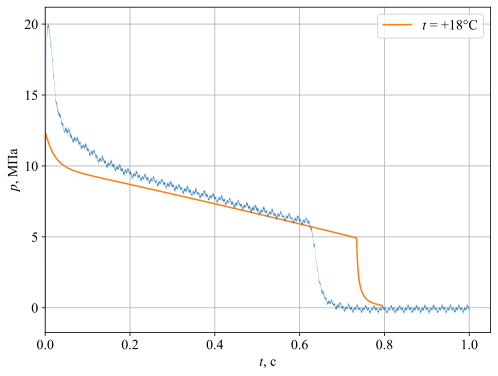

In [62]:
plt.figure(figsize = (8,6))
plt.plot(res18['t'], res18['p']/1e6, c = 'tab:orange', label = '$\mathit{t}$ = +18°C')
# plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
#plt.axhline(4.5e6/1e6,ls = '--',c = 'tab:blue')
# plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
# plt.plot(0.7/0.4*res50['t'],0.95*res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
# plt.plot(0.7/0.4*res_50['t'],0.95*res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
# plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')
plt.plot(x, y, linewidth= 0.1)
print(sum(res18['p'])/len(res18['p'])*1e-6)
plt.xlim(0)
#plt.ylim(0.1)
# plt.ylim(top = 18.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend(loc = 'upper right')
plt.grid()
plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
plt.show()

7.097322716671138


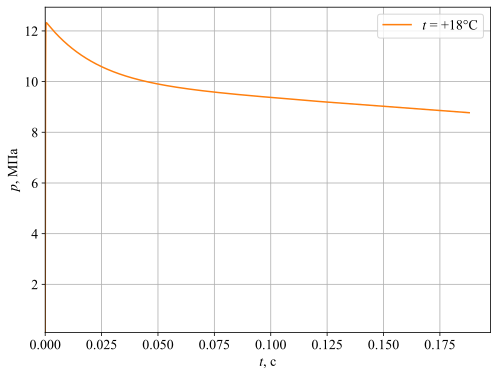

In [63]:
plt.figure(figsize = (8,6))
plt.plot(res18['t'][res18['t'] <= 0.188], res18['p'][res18['t'] <= 0.188]/1e6, c = 'tab:orange', label = '$\mathit{t}$ = +18°C')
# plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
# plt.axhline(4.5e6/1e6,ls = '--',c = 'tab:blue')
# plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
# plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
# plt.plot(0.7/0.4*res50['t'],0.95*res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
# plt.plot(0.7/0.4*res_50['t'],0.95*res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
# plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')
print(sum(res18['p'])/len(res18['p'])*1e-6)
plt.xlim(0)
plt.ylim(0.1)
# plt.ylim(top = 18.5)
plt.xlabel('$\mathit{t}$, с')
plt.ylabel('$\mathit{p}$, МПа')
plt.legend(loc = 'upper right')
plt.grid()
plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
plt.show()

In [16]:
D, L, deff = [], [], []
for D_N in tqdm(range(15, 26)):
    D_N *= 1e-3
    D.append(D_N)
    for L_z in range(10, 22):
        L_z *= 1e-3
        L.append(L_z)
        count = 0
        try:
            m = 1 # т.к. количесвто шашек
            #print("D_N, мм =", D_N*1e3)
            D_V=(D_N-4*e_0)
            #print("D_V, мм =", D_V*1e3)
            #print("L_z, мм =", L_z*1e3)

            W_0 = np.pi / 4 * (23e-3)**2 * L_z - np.pi/4 * (D_N**2 - D_V**2)*L_z     
            F_oxl = 23e-3*np.pi*L_z
            #print(f'Начальный свободный объем W0 = {W_0 * 1e5:.3f} * 10^5 м3\n',
            #    f'Площадь, омываемая ПС F_oxl = {F_oxl:.4f} м2')

            vospl = Vosplamenitel(F_kr,F_oxl,W_0)
            # vospl.get_results()
            # vospl.t_v

            pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
            mu_c = 0.95
            e_max = e_0
            Q_t = propel.k / (propel.k - 1) * propel.R * propel.T0
            #print("Q_t =", Q_t)

            res18 = res_int(T_N)

            # plt.figure(figsize = (8,6))
            # plt.plot(res18['t'], res18['p']/1e6, c = 'tab:orange', label = '$\mathit{t}$ = +18°C')
            # # plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
            # plt.axhline(4.5e6/1e6,ls = '--',c = 'tab:blue')
            # # plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
            # # plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
            # # plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
            # # plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
            # # plt.plot(0.7/0.4*res50['t'],0.95*res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
            # # plt.plot(0.7/0.4*res_50['t'],0.95*res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
            # # plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')
            # plt.plot(x, y, linewidth= 0.1)
            # #print(sum(res18['p'])/len(res18['p'])*1e-6)
            # plt.xlim(0)
            # #plt.ylim(0.1)
            # # plt.ylim(top = 18.5)
            # plt.xlabel('$\mathit{t}$, с')
            # plt.ylabel('$\mathit{p}$, МПа')
            # plt.legend(loc = 'upper right')
            # plt.grid()
            # plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
            # plt.show()

            
            for i in range(len(res18['t'])):
                count += (y[i] - res18['p'][i]/1e6)
            count /= len(res18['t'])
            print('Различие', count)
        except:
            print('Нет решения')
        deff.append(count)
        

D_N, мм = 15.0
L_z, мм = 10.0
Различие 6.908618001599331
D_N, мм = 15.0
L_z, мм = 11.0
Различие 6.655231313076252
D_N, мм = 15.0
L_z, мм = 12.0
Различие 6.403809633891309
D_N, мм = 15.0
L_z, мм = 13.000000000000002
Различие 6.156881511300584
D_N, мм = 15.0
L_z, мм = 14.0
Различие 5.918805081708009
D_N, мм = 15.0
L_z, мм = 15.0
Различие 5.687868968245098
D_N, мм = 15.0
L_z, мм = 16.0
Различие 5.462298556349331
D_N, мм = 15.0
L_z, мм = 17.0
Различие 5.2451212477202365
D_N, мм = 15.0
L_z, мм = 18.000000000000004
Различие 5.033372622839198
D_N, мм = 15.0
L_z, мм = 19.0
Различие 4.826331131231499
D_N, мм = 15.0
L_z, мм = 20.0
Различие 4.626449621874737
D_N, мм = 15.0
L_z, мм = 21.0
Различие 4.431577423650454
D_N, мм = 16.0
L_z, мм = 10.0
Различие 6.59371196811274
D_N, мм = 16.0
L_z, мм = 11.0
Различие 6.309233735405658
D_N, мм = 16.0
L_z, мм = 12.0
Различие 6.030762625806171
D_N, мм = 16.0
L_z, мм = 13.000000000000002
Различие 5.764081236199324
D_N, мм = 16.0
L_z, мм = 14.0
Различие 5.50455

C:\Users\i_Ber\AppData\Local\Temp\ipykernel_4484\2655845858.py:20: RuntimeWarning: invalid value encountered in double_scalars
  S0_v1 = self.p_max * self.b2 * ((self.m / (self.t_v * self.b2)) ** (-self.m / (self.t_v * self.b2 - self.m)))
C:\Users\i_Ber\AppData\Local\Temp\ipykernel_4484\2655845858.py:54: RuntimeWarning: overflow encountered in exp
  return p1 * np.exp(- self.b2 * t) - p2 * np.exp(- self.m * t / self.t_v)


In [19]:
xx, yy, zz = [], [], []
D, L = [], []
for D_N in range(15, 26):
    D_N *= 1e-3
    D.append(D_N)
for L_z in range(10, 22):
    L_z *= 1e-3
    L.append(L_z)
for i in range(len(D)):
    for j in range(len(L)):
        xx.append(D[i])
        yy.append(L[j])
        zz.append(abs(deff[j + i*len(L)]))

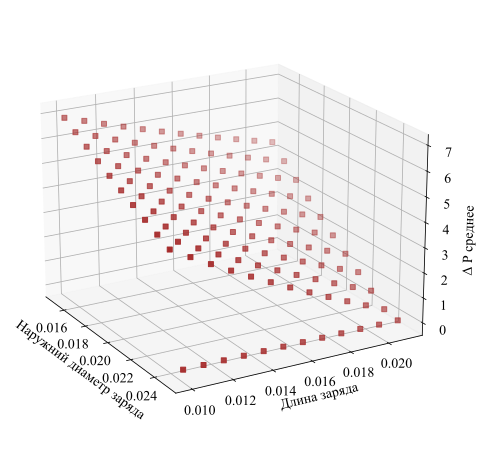

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, zdir='z', c= 'brown', marker='s', s=25)
plt.xlabel("Наружний диаметр заряда")
plt.ylabel("Длина заряда")
ax.set_zlabel(r'$\Delta$ P среднее', rotation=90)
ax.view_init(20, -30)

In [28]:
D, L, deff = [], [], []
for D_N in tqdm(range(220, 261)):
    D_N *= 1e-4
    D.append(D_N)
    for L_z in range(180, 221):
        L_z *= 1e-4
        L.append(L_z)
        count = 0
        try:
            m = 1 # т.к. количесвто шашек
            #print("D_N, мм =", D_N*1e3)
            D_V=(D_N-4*e_0)
            #print("D_V, мм =", D_V*1e3)
            #print("L_z, мм =", L_z*1e3)

            W_0 = np.pi / 4 * (23e-3)**2 * L_z - np.pi/4 * (D_N**2 - D_V**2)*L_z     
            F_oxl = 23e-3*np.pi*L_z
            #print(f'Начальный свободный объем W0 = {W_0 * 1e5:.3f} * 10^5 м3\n',
            #    f'Площадь, омываемая ПС F_oxl = {F_oxl:.4f} м2')

            vospl = Vosplamenitel(F_kr,F_oxl,W_0)
            # vospl.get_results()
            # vospl.t_v

            pi = lambda lmbd, k: (1 - (k - 1)/(k + 1)*lmbd**2) ** (k / (k - 1))
            mu_c = 0.95
            e_max = e_0
            Q_t = propel.k / (propel.k - 1) * propel.R * propel.T0
            #print("Q_t =", Q_t)

            res18 = res_int(T_N)

            # plt.figure(figsize = (8,6))
            # plt.plot(res18['t'], res18['p']/1e6, c = 'tab:orange', label = '$\mathit{t}$ = +18°C')
            # # plt.axhline(p1_max/1e6,ls = '--',c = 'tab:red')
            # plt.axhline(4.5e6/1e6,ls = '--',c = 'tab:blue')
            # plt.axhline(p1N/1e6,ls = '--',c = 'tab:green')
            # plt.text(t_g + vospl.t_vsp - 2e-3,p1_min /1e6 + 3,'$\mathit{p}_{min}$')
            # plt.text(t_g + vospl.t_vsp - 2e-3,p1N /1e6 + 3,'$\mathit{p}_{N}$')
            # plt.text(t_g + vospl.t_vsp - 2e-3,p1_max /1e6 + 3,'$\mathit{p}_{max}$')
            # plt.plot(0.7/0.4*res50['t'],0.95*res50['p']/1e6, c = 'tab:red', label = '$\mathit{t}$ = +50°C')
            # plt.plot(0.7/0.4*res_50['t'],0.95*res_50['p']/1e6, c = 'tab:blue', label = '$\mathit{t}$ = $-$50°C')
            # plt.axvline(t_g + vospl.t_vsp,ls = '--',c = 'grey', label = '$\mathit{t}_{в}$ + $\mathit{t}_г$')
            # plt.plot(x, y, linewidth= 0.1)
            # #print(sum(res18['p'])/len(res18['p'])*1e-6)
            # plt.xlim(0)
            # #plt.ylim(0.1)
            # # plt.ylim(top = 18.5)
            # plt.xlabel('$\mathit{t}$, с')
            # plt.ylabel('$\mathit{p}$, МПа')
            # plt.legend(loc = 'upper right')
            # plt.grid()
            # plt.savefig('Инд p.svg', dpi=500, bbox_inches='tight')
            # plt.show()

            
            for i in range(len(res18['t'])):
                count += (y[i] - res18['p'][i]/1e6)
            count /= len(res18['t'])
            #print('Различие', count)
        except:
            print('Нет решения')
        deff.append(count)
        

  0%|          | 0/41 [00:00<?, ?it/s]

Различие 1.929208252434151
Различие 1.8974057382767167


c:\Users\i_Ber\OneDrive\Documents\GitHub\peuro-lr\LR1_idk_orevo\prop.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return 6.45e-3 * p**-0.095


Различие 1.865675403378679
Различие 1.8340364874382942
Различие 1.8026077094587187
Различие 1.7711306429822007
Различие 1.7398105493917586
Различие 1.7082961989325147
Различие 1.676963307416981
Различие 1.6457012793466004
Различие 1.6144223734111052
Различие 1.5833451213744412
Различие 1.5524006810849265
Различие 1.5215672402305427
Различие 1.490832947901842
Различие 1.4602270161792865
Различие 1.4296174211504398
Различие 1.3992026254258383
Различие 1.3687403574553
Различие 1.338327948330855
Различие 1.3081103578739306
Различие 1.277976049135079
Различие 1.2480168571058323
Различие 1.2180715881065622
Различие 1.1882713545875774
Различие 1.1584903467089407
Различие 1.1287410749129512
Различие 1.0989190589407516
Различие 1.0692191148228756
Различие 1.039527246199529
Различие 1.0099070833175101
Различие 0.980358779450383
Различие 0.9508875263004657
Различие 0.9215587898895794
Различие 0.8922276042704149
Различие 0.8629378859629689
Различие 0.8336878642446817
Различие 0.8043758414106704
Ра

  2%|▏         | 1/41 [00:39<26:33, 39.83s/it]

Различие 0.7168736457154145
Различие 1.8887008361923066
Различие 1.8567454497589329
Различие 1.8248941598537718
Различие 1.793106156651874
Различие 1.7614110480597804
Различие 1.7299063053655979
Различие 1.698172309351191
Различие 1.666636014234148
Различие 1.6350280131343808
Различие 1.603657109202171
Различие 1.5723716253495326
Различие 1.5412073348466606
Различие 1.5101546502081968
Различие 1.4792190777376133
Различие 1.4483902968974776
Различие 1.4175820836278834
Различие 1.3868389113333248
Различие 1.3561775611014797
Различие 1.325552851849211
Различие 1.2951284198097062
Различие 1.2647845654347731
Различие 1.2346144406372814
Различие 1.2044633408724186
Различие 1.1744610540790932
Различие 1.144399590280203
Различие 1.1144481918776938
Различие 1.0845057465777599
Различие 1.0546142642031624
Различие 1.0246338142032525
Различие 0.9948133682294226
Различие 0.9650664819075249
Различие 0.9354749985410304
Различие 0.9058674779883966
Различие 0.876337974325205
Различие 0.8468503799274257

  5%|▍         | 2/41 [01:18<25:22, 39.05s/it]

Различие 0.6705537592581545
Различие 1.848097090565018
Различие 1.8160283305363638
Различие 1.7841584072980734
Различие 1.752241707387846
Различие 1.7204136107206052
Различие 1.6886162856885611
Различие 1.656734061341498
Различие 1.6250411817159836
Различие 1.5933170592737553
Различие 1.5618121492387
Различие 1.5304340092994817
Различие 1.499046375000291
Различие 1.4678955723053508
Различие 1.436856443559005
Различие 1.4058473941122867
Различие 1.374897248611079
Различие 1.3440350815153008
Различие 1.313309387116362
Различие 1.2825723962860696
Различие 1.2520062107267396
Различие 1.2215458167633833
Различие 1.191273145634697
Различие 1.1609887155830638
Различие 1.1308116115952584
Различие 1.1006476670593235
Различие 1.0704274746392637
Различие 1.0403346275560077
Различие 1.010233064829606
Различие 0.9802108471335791
Различие 0.9502699013244672
Различие 0.9203951827280918
Различие 0.8905883891642055
Различие 0.8608608859230693
Различие 0.8311747966418711
Различие 0.8014478235675747
Разл

  7%|▋         | 3/41 [01:54<23:59, 37.87s/it]

Различие 0.6243515351967134
Различие 1.8077208223461942
Различие 1.7754983582378467
Различие 1.743376175154935
Различие 1.7114647559150717
Различие 1.6793461860451735
Различие 1.6472482727874882
Различие 1.6153443273018662
Различие 1.5833901940108113
Различие 1.5516833847462015
Различие 1.5199602668795726
Различие 1.4884720971775902
Различие 1.4571165897535365
Различие 1.4258515068945448
Различие 1.3946449427434133
Различие 1.3634803767676797
Различие 1.3324157402872931
Различие 1.3013666851583698
Различие 1.2704230669670653
Различие 1.2396479475274276
Различие 1.2090720480273922
Различие 1.1785007877500424
Различие 1.1480126571908198
Различие 1.11763647960924
Различие 1.0871867299553148
Различие 1.0568444415616003
Различие 1.0265544743428794
Различие 0.9962540608608361
Различие 0.9659449001212496
Различие 0.9358033966197008
Различие 0.9057286915572126
Различие 0.8757227294400207
Различие 0.8457953654741621
Различие 0.8159102180474983
Различие 0.7859850216784466
Различие 0.756158782975

 10%|▉         | 4/41 [02:30<22:54, 37.15s/it]

Различие 0.5782632483647326
Различие 1.7674136544782513
Различие 1.7350640468996517
Различие 1.7028071573393664
Различие 1.6706256964109585
Различие 1.6383241647298306
Различие 1.6060683620846437
Различие 1.5740319665339189
Различие 1.541977989448018
Различие 1.5101530016542315
Различие 1.4783252373178262
Различие 1.4467489936880416
Различие 1.4152615757193274
Различие 1.38386610007418
Различие 1.3523788560854697
Различие 1.321101329356347
Различие 1.2898482625891257
Различие 1.2587922696878326
Различие 1.2277947800284246
Различие 1.1969213365425408
Различие 1.1661407370264472
Различие 1.1355268737758113
Различие 1.104878150299235
Различие 1.0742292975445193
Различие 1.0436802033310786
Различие 1.0131834131631097
Различие 0.9826027754214238
Различие 0.952171652725608
Различие 0.9218313815892839
Различие 0.8915495689518548
Различие 0.8613391397025421
Различие 0.8312039466790189
Различие 0.8011347408602661
Различие 0.7710109256760994
Различие 0.7409085631469419
Различие 0.710842184705147

 12%|█▏        | 5/41 [03:06<21:57, 36.60s/it]

Различие 0.5322887017928518
Различие 1.7271730918583892
Различие 1.694704108403966
Различие 1.6622020169274703
Различие 1.629825615443836
Различие 1.5973571307849448
Различие 1.5649653333716635
Различие 1.5327021014268638
Различие 1.500648045255858
Различие 1.4685988912410097
Различие 1.4367989985809346
Различие 1.4051047391261677
Различие 1.373503332513689
Различие 1.3418043909798016
Различие 1.3103162320192034
Различие 1.2788541228755343
Различие 1.2474904331734464
Различие 1.2162815939413207
Различие 1.1851929303639184
Различие 1.154278556030723
Различие 1.12337923968428
Различие 1.0925340256188225
Различие 1.0617551255415851
Различие 1.0309364401234848
Различие 1.0002327039746874
Различие 0.969447883831217
Различие 0.9388150158191174
Различие 0.9082696747698913
Различие 0.877708859522657
Различие 0.8472976840662393
Различие 0.816962208073157
Различие 0.7866938719948717
Различие 0.7563701249699382
Различие 0.7260680143129699
Различие 0.6958028510039846
Различие 0.6656027166203616
Ра

 15%|█▍        | 6/41 [03:42<21:09, 36.27s/it]

Различие 0.4864747389337604
Различие 1.6870180127586656
Различие 1.6543454442290508
Различие 1.6216135969704373
Различие 1.5890628765453523
Различие 1.5564512658367342
Различие 1.5239744738725434
Различие 1.4915672527444235
Различие 1.4594202348674599
Различие 1.427277609139756
Различие 1.3953649530430419
Различие 1.3635611765228939
Различие 1.331646488188433
Различие 1.2999453232737888
Различие 1.2682750076967826
Различие 1.2366973926280147
Различие 1.2052644973001636
Различие 1.1739624448656025
Различие 1.1427554429898195
Различие 1.1116500350983012
Различие 1.0806690992920236
Различие 1.0496202988346324
Различие 1.0185969846850338
Различие 0.9876899612540536
Различие 0.9567120791297721
Различие 0.9258707954586194
Различие 0.8951148383762499
Различие 0.8643531384708238
Различие 0.8337381523731545
Различие 0.8031985073224381
Различие 0.7727321103854184
Различие 0.7422059554236827
Различие 0.7117136484621943
Различие 0.68125400186755
Различие 0.6508487905401867
Различие 0.6205076283943

 17%|█▋        | 7/41 [04:18<20:36, 36.36s/it]

Различие 0.440627035963531
Различие 1.6469068126267044
Различие 1.6139551666615648
Различие 1.5811985201877636
Различие 1.5483693864115555
Различие 1.5156518457663866
Различие 1.4830259585638372
Различие 1.4506606437387792
Различие 1.4182933131089577
Различие 1.3860429420401699
Различие 1.3540306988271533
Различие 1.3220095851349298
Различие 1.289991892550516
Различие 1.2581177714522536
Различие 1.2263261838710695
Различие 1.1946668967619025
Различие 1.1631487981075104
Различие 1.1317297195747578
Различие 1.1004133969293444
Различие 1.0691555734177742
Различие 1.0379016472745164
Различие 1.0067573368409053
Различие 0.9755660625957009
Различие 0.94445944993211
Различие 0.9133416887199484
Различие 0.882370238937002
Различие 0.8514099043404064
Различие 0.8205892782581153
Различие 0.7898482231469337
Различие 0.7591147497383083
Различие 0.7283885603816042
Различие 0.697696004085929
Различие 0.6670366115694882
Различие 0.6364319835121471
Различие 0.6058929532316624
Различие 0.575525700020190

 20%|█▉        | 8/41 [04:55<20:01, 36.41s/it]

Различие 0.39491766522636396
Различие 1.6068635517466185
Различие 1.5737540279243205
Различие 1.5407066702416232
Различие 1.5077539649296992
Различие 1.474910718076235
Различие 1.4421972681656239
Различие 1.4097237439398491
Различие 1.37726206657116
Различие 1.3449202947417425
Различие 1.312695673588807
Различие 1.2805572524731852
Различие 1.2483867153254717
Различие 1.2163788518343803
Различие 1.1844734646446642
Различие 1.1527522855805394
Различие 1.1211148222400225
Различие 1.0896013396040511
Различие 1.0581247913744436
Различие 1.0266802463375941
Различие 0.995244859284888
Различие 0.9639392847833296
Различие 0.9325471211259213
Различие 0.9012264701633595
Различие 0.8700436102761437
Различие 0.8388816839947364
Различие 0.8078570920788117
Различие 0.776905256168114
Различие 0.7459712867497217
Различие 0.715050764911825
Различие 0.6841578086596848
Различие 0.6533004618500746
Различие 0.622494520362116
Различие 0.5917494417205942
Различие 0.5611220448822485
Различие 0.5305964385530725

 22%|██▏       | 9/41 [05:31<19:23, 36.37s/it]

Различие 0.34923866925528657
Различие 1.5667313086872219
Различие 1.5334633390376036
Различие 1.5002857252802013
Различие 1.4672297993158856
Различие 1.434285621829028
Различие 1.401464160701744
Различие 1.3688955012162938
Различие 1.336322646115617
Различие 1.3039034398086644
Различие 1.2714401720766162
Различие 1.239170754964041
Различие 1.2068349132516447
Различие 1.1747103387118192
Различие 1.1427727246887338
Различие 1.110922565941602
Различие 1.0791905824380958
Различие 1.047510787278407
Различие 1.0158679968762145
Различие 0.9842329356520817
Различие 0.9526476251337483
Различие 0.9211267035376686
Различие 0.889596532696925
Различие 0.858135407566337
Различие 0.8268268405215196
Различие 0.795539501952082
Различие 0.7643810286358953
Различие 0.7332982713845222
Различие 0.702131219493012
Различие 0.6710372526566167
Различие 0.6399773765954871
Различие 0.6089599800449653
Различие 0.5780179864605
Различие 0.5471814077155904
Различие 0.5164575714674281
Различие 0.4858289042370549
Разл

 24%|██▍       | 10/41 [06:10<19:08, 37.05s/it]

Различие 0.30365226372309195
Различие 1.5266534070395028
Различие 1.4932479780840102
Различие 1.4599757835080218
Различие 1.4267943716284777
Различие 1.3937447574861872
Различие 1.360943901711363
Различие 1.3281415897422815
Различие 1.2954335038840374
Различие 1.2628465067175032
Различие 1.2302709946440626
Различие 1.1978151445854561
Различие 1.1654669587159223
Различие 1.133209427740744
Различие 1.1011482460142101
Различие 1.0691957395573293
Различие 1.0373192048993778
Различие 1.0054676137433745
Различие 0.9736286585546029
Различие 0.94183541441872
Различие 0.9100507481107277
Различие 0.8783734284960995
Различие 0.8467195029951854
Различие 0.8151225712125776
Различие 0.783705405544963
Различие 0.752265692459117
Различие 0.7209778279603933
Различие 0.6896224740214033
Различие 0.6583205654408768
Различие 0.627062607725137
Различие 0.595846875562516
Различие 0.5646997144160676
Различие 0.5336573569172254
Различие 0.5027188773453767
Различие 0.471894132666434
Различие 0.4411650719458258


 27%|██▋       | 11/41 [06:45<18:18, 36.62s/it]

Различие 0.2581419554499248
Различие 1.48676333870495
Различие 1.4532631256813657
Различие 1.4198407774817503
Различие 1.3865687945831713
Различие 1.3534203206616802
Различие 1.3204030540320097
Различие 1.287483129701659
Различие 1.2546755531765559
Различие 1.2218826355897872
Различие 1.1892152890996421
Различие 1.156550848608801
Различие 1.1241481076225737
Различие 1.0918734705419766
Различие 1.0596245314110249
Различие 1.0275367612068298
Различие 0.9954827295292813
Различие 0.9634499807474326
Различие 0.9314375867561995
Различие 0.8994636968677564
Различие 0.8674972936779012
Различие 0.8357020968706746
Различие 0.8039064784509553
Различие 0.7722121464503063
Различие 0.7406284049558396
Различие 0.7090749975314811
Различие 0.6775981388427466
Различие 0.646020725403346
Различие 0.614556599902939
Различие 0.5831415435290663
Различие 0.5518001007374846
Различие 0.5205425072078261
Различие 0.4894003180872028
Различие 0.45836955327818496
Различие 0.42743720389029677
Различие 0.3965907513085

 29%|██▉       | 12/41 [07:21<17:36, 36.44s/it]

Различие 0.21266047910555294
Различие 1.446839128874419
Различие 1.4132049043561328
Различие 1.3797029173421398
Различие 1.3463277647444407
Различие 1.313071766376382
Различие 1.279953927808551
Различие 1.2469234068094788
Различие 1.2139077258161717
Различие 1.1809381433683008
Различие 1.1481560468875858
Различие 1.115432849921741
Различие 1.082932417234125
Различие 1.0505386500276643
Различие 1.0182394443898999
Различие 0.9859242105645956
Различие 0.9536781627930694
Различие 0.9214531538196604
Различие 0.8892888172407537
Различие 0.8571224536557522
Различие 0.8251096736187284
Различие 0.7931033228479785
Различие 0.7611901803570306
Различие 0.7293410644732825
Различие 0.6976472755744799
Различие 0.665917847819766
Различие 0.6342036073204304
Различие 0.6025366851146416
Различие 0.5708475023567375
Различие 0.5393006744420867
Различие 0.5078417963921861
Различие 0.4764865533379573
Различие 0.4452467173905696
Различие 0.41407444146505523
Различие 0.38306382731626026
Различие 0.352056787269

 32%|███▏      | 13/41 [07:57<16:55, 36.26s/it]

Различие 0.16740165035790014
Различие 1.4071068089242567
Различие 1.3733686094378723
Различие 1.3397555557534997
Различие 1.306278199143822
Различие 1.2729299184139649
Различие 1.2396001080131018
Различие 1.206363216050395
Различие 1.1731866979673957
Различие 1.1401793477717825
Различие 1.1072203434493364
Различие 1.0744984792210008
Различие 1.0418063316880612
Различие 1.00929365456899
Различие 0.9768362111536691
Различие 0.9443910076554839
Различие 0.9119728520367364
Различие 0.8795985696108939
Различие 0.8472241427211821
Различие 0.8149229974145968
Различие 0.782718086917555
Различие 0.7505859859109976
Различие 0.7185379295556293
Различие 0.6866338621742207
Различие 0.6547061551106675
Различие 0.6227984098234908
Различие 0.590859385194773
Различие 0.5590304621636968
Различие 0.5272074954272984
Различие 0.4955477764218429
Различие 0.46398491393596636
Различие 0.43254198843637803
Различие 0.40121159849398935
Различие 0.36995592970736385
Различие 0.33874684554067674
Различие 0.307602594

 34%|███▍      | 14/41 [08:33<16:15, 36.13s/it]

Различие 0.12225135865602281
Различие 1.3673506317327875
Различие 1.333506619205249
Различие 1.2998067429739122
Различие 1.266220499623664
Различие 1.232689370072133
Различие 1.1992282306683815
Различие 1.1659525239612283
Различие 1.1326168533176464
Различие 1.0994041999107114
Различие 1.066478252782865
Различие 1.0335584313193018
Различие 1.0008436160012095
Различие 0.9681679421588493
Различие 0.9354518820753298
Различие 0.9028317640261393
Различие 0.8702465045737553
Различие 0.8376661281269999
Различие 0.8051621997354887
Различие 0.7727473257888128
Различие 0.7404026045302641
Различие 0.7081406777565945
Различие 0.6760284662464366
Различие 0.6439022594639439
Различие 0.6117284189471403
Различие 0.5796577778637513
Различие 0.547554293571001
Различие 0.5155972210437998
Различие 0.48372044471425046
Различие 0.4518999385244567
Различие 0.42024969082908664
Различие 0.38871204325899333
Различие 0.35724751572092006
Различие 0.32584334099556905
Различие 0.2944971016656455
Различие 0.26320940

 37%|███▋      | 15/41 [09:09<15:42, 36.24s/it]

Различие 0.0772095899811656
Различие 1.3277979295826778
Различие 1.2938586090606445
Различие 1.2600358208205082
Различие 1.2263179839188276
Различие 1.1926176898278464
Различие 1.1590307612523847
Различие 1.1254788306706422
Различие 1.0921257859679203
Различие 1.0588719564542914
Различие 1.0257401943749633
Различие 0.9927942805684007
Различие 0.959846521436028
Различие 0.9270043553142685
Различие 0.8941723599678348
Различие 0.8613926860660662
Различие 0.828530972320338
Различие 0.7958183126504111
Различие 0.7631750380278238
Различие 0.7306274174058084
Различие 0.6981562750825736
Различие 0.6658254538067457
Различие 0.6335147553992116
Различие 0.6011421441287216
Различие 0.5688657197159392
Различие 0.536559835087492
Различие 0.5043932415163564
Различие 0.4722497657510992
Различие 0.44027277758041156
Различие 0.40836107728596766
Различие 0.37661787660806495
Различие 0.34494615067342127
Различие 0.31335216363287194
Различие 0.281791548817268
Различие 0.2503107803856917
Различие 0.21889058

 39%|███▉      | 16/41 [09:47<15:13, 36.54s/it]

Различие 0.0322106963017329
Различие 1.2883387887909181
Различие 1.2542787321109186
Различие 1.2203589342000885
Различие 1.1863388234437329
Различие 1.1526243789378101
Различие 1.1188588915903317
Различие 1.0851895921594492
Различие 1.051689829666491
Различие 1.0183407893773688
Различие 0.9851661294399082
Различие 0.9520138621637563
Различие 0.9189567801546762
Различие 0.8859314304904106
Различие 0.8528659214692251
Различие 0.8198871929048672
Различие 0.7869458670348422
Различие 0.7540982725564314
Различие 0.7213233194010286
Различие 0.6886498301365197
Различие 0.6560416344184287
Различие 0.6235260045398202
Различие 0.5909598409214789
Различие 0.5584838185394633
Различие 0.5259773266804281
Различие 0.4935390247101131
Различие 0.4612399163646192
Различие 0.4290029466283038
Различие 0.39692984824349037
Различие 0.3649725665406844
Различие 0.3330972948381751
Различие 0.30126816256816136
Различие 0.2695033533120665
Различие 0.23781624059868212
Различие 0.206200532073767
Различие 0.17460543

 41%|████▏     | 17/41 [10:23<14:35, 36.50s/it]

Различие -0.012715198536189213
Различие 1.2489568370819155
Различие 1.2147115141498281
Различие 1.1805757426628405
Различие 1.146548118485683
Различие 1.1125638186856417
Различие 1.0786682722319416
Различие 1.045018792895246
Различие 1.011434277221791
Различие 0.9779578073430109
Различие 0.9446577163653763
Различие 0.9113479575793413
Различие 0.8781046191993714
Различие 0.8448209242377716
Различие 0.8116578721117853
Различие 0.778495892786911
Различие 0.7453721642835394
Различие 0.712381828334509
Различие 0.6795025055857489
Различие 0.6466758676142413
Различие 0.6139445354185731
Различие 0.5812607481016957
Различие 0.5485143488712508
Различие 0.5158076013437126
Различие 0.48316285385721774
Различие 0.45064775222941617
Различие 0.41819595077808763
Различие 0.3859120093558614
Различие 0.35370131404298016
Различие 0.32161809250409007
Различие 0.2896267883398531
Различие 0.2576582194931401
Различие 0.22576604871237416
Различие 0.1939147686596043
Различие 0.16212000917276267
Различие 0.1304

 44%|████▍     | 18/41 [10:59<13:58, 36.45s/it]

Различие -0.057560241554895496
Различие 1.2095703817474042
Различие 1.1752425594898075
Различие 1.1409710172035894
Различие 1.106796450246065
Различие 1.0726737163921791
Различие 1.0386750897503514
Различие 1.004877841094672
Различие 0.971245353420473
Различие 0.9376587562706427
Различие 0.9041353744693335
Различие 0.8706898725960748
Различие 0.8372103277543664
Различие 0.8038344012926381
Различие 0.7703979908400985
Различие 0.7371209526703583
Различие 0.7039216836511942
Различие 0.6708189533018034
Различие 0.6377814589744623
Различие 0.6048412088221139
Различие 0.5719168495043695
Различие 0.5389570517887996
Различие 0.5060488931191852
Различие 0.47324934027541044
Различие 0.44046302422433187
Различие 0.4078038437991699
Различие 0.3753066412565703
Различие 0.3428814824624993
Различие 0.3105814815214521
Различие 0.27839428479788614
Различие 0.2461847935747662
Различие 0.21409036846433518
Различие 0.18206739460234023
Различие 0.1500746138766489
Различие 0.11816031920865586
Различие 0.086

 46%|████▋     | 19/41 [11:35<13:19, 36.35s/it]

Различие -0.10239530908620445
Различие 1.1703353903443445
Различие 1.1358310836756322
Различие 1.1014409256284847
Различие 1.067088083055381
Различие 1.0328535797031353
Различие 0.9988101812675437
Различие 0.9648827610098359
Различие 0.9310875226426368
Различие 0.8974079198154685
Различие 0.863702710795027
Различие 0.8300118146835449
Различие 0.7964298259488323
Различие 0.7628531961502704
Различие 0.7292896717986924
Различие 0.6958866591630732
Различие 0.6625572776224704
Различие 0.629309969195104
Различие 0.5960983059329331
Различие 0.5629849688575426
Различие 0.5298873898800908
Различие 0.4967650824250248
Различие 0.4636961523008381
Различие 0.43071108749270903
Различие 0.3978202124124202
Различие 0.3651041981405676
Различие 0.33246613251840434
Различие 0.2999667631752677
Различие 0.26753905303360026
Различие 0.23515738701162975
Различие 0.20285857553618664
Различие 0.17061910234462607
Различие 0.1384109588360243
Различие 0.10628965694895735
Различие 0.07426019955001899
Различие 0.04

 49%|████▉     | 20/41 [12:12<12:41, 36.28s/it]

Различие -0.14722219086049398
Различие 1.1311185425839911
Различие 1.096506359138285
Различие 1.0619372529624804
Различие 1.0274671389578123
Различие 0.9931676215981281
Различие 0.9590216921540338
Различие 0.9249831150651334
Различие 0.8910409682068335
Различие 0.8571235443626752
Различие 0.823293840165384
Различие 0.7894501893192807
Различие 0.7556572580627611
Различие 0.7218869788863482
Различие 0.6882503334969945
Различие 0.6547110073696887
Различие 0.6211963651251938
Различие 0.5878317290606856
Различие 0.5545167041509453
Различие 0.5211564140520893
Различие 0.4878380517275871
Различие 0.45455793298186553
Различие 0.42141004529365406
Различие 0.3883094086948217
Различие 0.3553225487378566
Различие 0.32247085726977875
Различие 0.28976459160869883
Различие 0.25712118036632337
Различие 0.2245305855050741
Различие 0.1920320868413391
Различие 0.15956498970117083
Различие 0.1271718045681962
Различие 0.09485463355283565
Различие 0.06259080375778865
Различие 0.03055231071484557
Различие -0

 51%|█████     | 21/41 [12:48<12:04, 36.23s/it]

Различие -0.19199362556290606
Различие 1.091992554459489
Различие 1.057211594342533
Различие 1.0225104050307003
Различие 0.9879657666859176
Различие 0.9535815000800819
Различие 0.919306468537168
Различие 0.8851472962901282
Различие 0.8510347457532096
Различие 0.8169366899946519
Различие 0.782930125721075
Различие 0.74889515588342
Различие 0.7149495283430141
Различие 0.6810449241621247
Различие 0.6472761892293128
Различие 0.6135520355468724
Различие 0.5799645540937634
Различие 0.5464620182781812
Различие 0.5129086604184794
Различие 0.4793800628143366
Различие 0.44588927363258546
Различие 0.41247638620023136
Различие 0.3791612570813688
Различие 0.3459627305796058
Различие 0.3129313714875096
Различие 0.2799774952360334
Различие 0.24714643936073688
Различие 0.21433030545815007
Различие 0.18162444437843814
Различие 0.14894914302215068
Различие 0.11635035648875702
Различие 0.08382377845647852
Различие 0.05133258301632073
Различие 0.019082428927386114
Различие -0.013071678804635877
Различие -

 54%|█████▎    | 22/41 [13:25<11:32, 36.44s/it]

Различие -0.23671612625869953
Различие 1.053008176025866
Различие 1.0179802792510828
Различие 0.9831687450701696
Различие 0.948566592804078
Различие 0.914064992216297
Различие 0.879679302876385
Различие 0.8453596068174805
Различие 0.8110533071251415
Различие 0.7767718767017091
Различие 0.742612729551228
Различие 0.7083726009938683
Различие 0.6743147626145193
Различие 0.6402718432180541
Различие 0.6063959659800733
Различие 0.5725205420517354
Различие 0.5388007703905622
Различие 0.5050624909387247
Различие 0.47133155938896387
Различие 0.43764624955283377
Различие 0.4040199709848823
Различие 0.37047590473320613
Различие 0.3370594135510911
Различие 0.30376360909573247
Различие 0.27063041083347744
Различие 0.23755115281918057
Различие 0.20454367704463816
Различие 0.17162503659911063
Различие 0.13873602103742844
Различие 0.10595006623497742
Различие 0.07320470691861788
Различие 0.0405123784794876
Различие 0.008035815100053408
Различие -0.024341967361000326
Различие -0.05659475096182045
Разли

 56%|█████▌    | 23/41 [14:02<11:00, 36.69s/it]

Различие -0.28135969421148904
Различие 1.013965298674711
Различие 0.9788334689684486
Различие 0.9439772527571241
Различие 0.9092491484860951
Различие 0.874643366134667
Различие 0.8401039312798559
Различие 0.8056030225863524
Различие 0.7711176802800609
Различие 0.7366737964026233
Различие 0.7023117975460967
Различие 0.667948900509749
Различие 0.633757792933578
Различие 0.5995926476094051
Различие 0.5655587240401754
Различие 0.5315703669758446
Различие 0.4976554307889132
Различие 0.46370898703150054
Различие 0.429814418980901
Различие 0.3959693857782552
Различие 0.362210440295479
Различие 0.32856766568934226
Различие 0.2950601847696147
Различие 0.26167243673234897
Различие 0.22838057319763913
Различие 0.1952104951841608
Различие 0.16203748692687886
Различие 0.12897619105257932
Различие 0.0959623171703929
Различие 0.06300156255448223
Различие 0.0301058942324414
Различие -0.0025916498090058837
Различие -0.03517728361528592
Различие -0.06764927754896678
Различие -0.10008840599445455
Различи

 59%|█████▊    | 24/41 [14:39<10:24, 36.72s/it]

Различие -0.3259276405368805
Различие 0.9750232783842255
Различие 0.9399023394273932
Различие 0.904871487738085
Различие 0.8700284652908044
Различие 0.835281255828338
Различие 0.8005719958227914
Различие 0.7658787272010636
Различие 0.7312401894877958
Различие 0.696591732379153
Различие 0.6620876048019924
Различие 0.6276065243275054
Различие 0.5932735092163979
Различие 0.5589751531025332
Различие 0.5248249776076823
Различие 0.4906678376752475
Различие 0.45651972613423997
Различие 0.42240919120315085
Различие 0.388355404419825
Различие 0.35438532507782516
Различие 0.32051310253768484
Различие 0.28678115062056636
Различие 0.2531596896559728
Различие 0.2196517156014409
Различие 0.18625471474528288
Различие 0.1529023196944476
Различие 0.11960832574415453
Различие 0.08638939993430635
Различие 0.05322313397842901
Различие 0.020144836323122105
Различие -0.012806571979499873
Различие -0.0456021048659321
Различие -0.07827995687988336
Различие -0.11092170875735545
Различие -0.1434727037838738
Раз

 61%|██████    | 25/41 [15:21<10:12, 38.26s/it]

Различие -0.370418525026365
Различие 0.936204986620742
Различие 0.9010089505612083
Различие 0.8659238755382264
Различие 0.8308936163161181
Различие 0.79598849868164
Различие 0.76108104423201
Различие 0.7262198044859476
Различие 0.6913902216135736
Различие 0.6566479556653954
Различие 0.6219511417568224
Различие 0.5873371647594652
Различие 0.5528761896633818
Различие 0.5184503640810593
Различие 0.48415898371376953
Различие 0.4497539543916547
Различие 0.41544434524258006
Различие 0.3811716639079807
Различие 0.34698218436489653
Различие 0.3128997743933402
Различие 0.27892777399434376
Различие 0.24509526726863862
Различие 0.21137569046575086
Различие 0.17776546997424145
Различие 0.1441730215317978
Различие 0.11069580361836935
Различие 0.07726717027850565
Различие 0.04387767582599194
Различие 0.010591019124100313
Различие -0.022589692321540834
Различие -0.05558759883757649
Различие -0.08849404863964735
Различие -0.12132410812835703
Различие -0.15408926182877491
Различие -0.18679377907691355


 63%|██████▎   | 26/41 [16:02<09:48, 39.25s/it]

Различие -0.41482043519217615
Различие 0.8976273632075545
Различие 0.8622385525357443
Различие 0.8270603167261708
Различие 0.7919240050913031
Различие 0.7568240743885447
Различие 0.7217506778205033
Различие 0.6867212018982116
Различие 0.6517006171536244
Различие 0.6167742347597109
Различие 0.5819391670566951
Различие 0.5472167981277123
Различие 0.5126063403170219
Различие 0.47805124316461756
Различие 0.44351298875251277
Различие 0.4089471513216204
Различие 0.3744701686932413
Различие 0.3400663456645301
Различие 0.3057573231696176
Различие 0.27156320430964137
Различие 0.23750731197726363
Различие 0.20357361029654109
Различие 0.16972589107530858
Различие 0.13593748000414438
Различие 0.10222951663832659
Различие 0.06861026933002874
Различие 0.03501855460321811
Различие 0.001507437875185308
Различие -0.03191145126126603
Различие -0.0651162723948693
Различие -0.09823582544111012
Различие -0.13126205311357103
Различие -0.16424221019017982
Различие -0.19713672564097842
Различие -0.23002510713

 66%|██████▌   | 27/41 [16:51<09:48, 42.01s/it]

Различие -0.4590877904139686
Различие 0.8591469652881455
Различие 0.8237133018827566
Различие 0.7883168899827673
Различие 0.7530201628151941
Различие 0.7177296707259286
Различие 0.6824954434078394
Различие 0.6472658606562279
Различие 0.6121173218722474
Различие 0.5770678680300448
Различие 0.5421128389468838
Различие 0.5072871469157324
Различие 0.47250993942476427
Различие 0.4378059400441836
Различие 0.40301755541761664
Различие 0.36833901109588435
Различие 0.3336685189431525
Различие 0.2991275880425996
Различие 0.26472112755269556
Различие 0.23043809740415602
Различие 0.19628244143162146
Различие 0.16222411831990086
Различие 0.12823935668586856
Различие 0.09431478080213428
Различие 0.06045736580876915
Различие 0.026693387478667337
Различие -0.007035453382885588
Различие -0.04069451002453017
Различие -0.07411606662050639
Различие -0.10744357599632909
Различие -0.14067108127475908
Различие -0.17385953366548718
Различие -0.2069504711031905
Различие -0.2400365026952088
Различие -0.27313497

 68%|██████▊   | 28/41 [17:31<09:00, 41.61s/it]

Различие -0.5031488267432548
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


C:\Users\i_Ber\AppData\Local\Temp\ipykernel_4484\2655845858.py:20: RuntimeWarning: invalid value encountered in double_scalars
  S0_v1 = self.p_max * self.b2 * ((self.m / (self.t_v * self.b2)) ** (-self.m / (self.t_v * self.b2 - self.m)))
C:\Users\i_Ber\AppData\Local\Temp\ipykernel_4484\2655845858.py:54: RuntimeWarning: overflow encountered in exp
  return p1 * np.exp(- self.b2 * t) - p2 * np.exp(- self.m * t / self.t_v)


Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 71%|███████   | 29/41 [17:32<05:51, 29.30s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 73%|███████▎  | 30/41 [17:32<03:47, 20.67s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 76%|███████▌  | 31/41 [17:33<02:26, 14.63s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 78%|███████▊  | 32/41 [17:33<01:33, 10.40s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 80%|████████  | 33/41 [17:34<00:59,  7.44s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 83%|████████▎ | 34/41 [17:34<00:37,  5.36s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 85%|████████▌ | 35/41 [17:35<00:23,  3.90s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 88%|████████▊ | 36/41 [17:36<00:14,  2.89s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 90%|█████████ | 37/41 [17:36<00:08,  2.17s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 93%|█████████▎| 38/41 [17:37<00:05,  1.67s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 95%|█████████▌| 39/41 [17:37<00:02,  1.31s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


 98%|█████████▊| 40/41 [17:37<00:01,  1.04s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


100%|██████████| 41/41 [17:38<00:00, 25.81s/it]

Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения
Нет решения


In [40]:
xx, yy, zz = [], [], []
D, L = [], []
minim = 10
for D_N in range(220, 261):
    D_N *= 1e-4
    D.append(D_N)
for L_z in range(180, 221):
    L_z *= 1e-4
    L.append(L_z)
for i in range(len(D)):
    for j in range(len(L)):
        xx.append(D[i])
        yy.append(L[j])
        if abs(deff[j + i*len(L)]) < minim and abs(deff[j + i*len(L)]) > 0:
            minim = abs(deff[j + i*len(L)])
            minim_D, minim_L = D[i], L[j]
        zz.append(abs(deff[j + i*len(L)]))
print(minim, round(minim_L, 6), round(minim_D, 6))

0.001405968239851175 0.0214 0.024


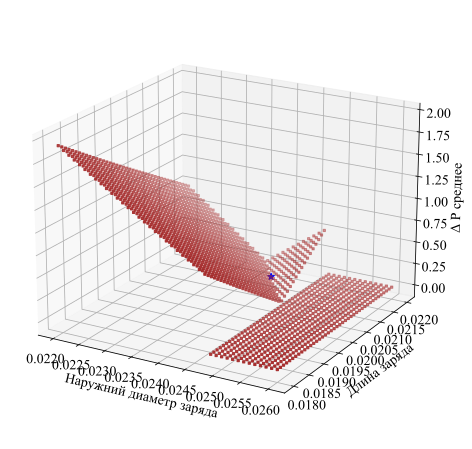

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, zdir='z', c = 'brown', marker='s', s=5)
ax.scatter(minim_D, minim_L, minim, c = 'blue', marker='*', s=50)
plt.xlabel("Наружний диаметр заряда")
plt.ylabel("Длина заряда")
ax.set_zlabel(r'$\Delta$ P среднее', rotation=90)
ax.view_init(20, -60)